## W3-CRISPR-mcBEST workflow



The workflow allows for the simultaneous targeted engineering of up to 28 individual situated bases in the genome of Streptomyces, as shown by Whitford et. al 2023, thereby enabling efficient single-step multi-target engineering13. Similar to workflow 2, this workflow employs the CRISPR-BEST methodology but instead of performing base-editing on a single gene the method incorporates multiple guide RNAs as an array into the same vector (Figure 4A). This significantly enhances the efficiency of high-throughput genetic studies. The pCRISPR-cBEST plasmid file can be downloaded on the page along with the genome file for S.coelicor (A3) and streptoAIM will generate your plasmids, primers, checking primers and analyze the overhangs the target genes(Figure 4, S6). 


In [1]:
import sys
import os
from pydna.dseqrecord import Dseqrecord
from teemi.build.PCR import primer_tm_neb
import pandas as pd
from datetime import datetime


# Ensure the src directory is in the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from streptocad.sequence_loading.sequence_loading import (
    load_and_process_plasmid, 
    check_and_convert_input,
    annotate_dseqrecord,
    process_specified_gene_sequences_from_record)


from streptocad.utils import polymerase_dict, dataframe_to_seqrecords, ProjectDirectory, extract_metadata_to_dataframe
from streptocad.crispr.guideRNAcas3_9_12 import extract_sgRNAs, SgRNAargs
from streptocad.crispr.crispr_best import (
    identify_base_editing_sites,
    filter_sgrnas_for_base_editing,
    process_base_editing
)

from streptocad.cloning.golden_gate_cloning import (
    GoldenGateCloning,
    create_overhang_dataframe,
    digest_amplicons_w_BsaI
)

from streptocad.primers.primer_analysis import analyze_primers_and_hairpins
from streptocad.primers.primer_generation import create_idt_order_dataframe
from streptocad.cloning.plasmid_processing import annotate_plasmid_with_sgrnas
from streptocad.primers.primer_generation import find_best_check_primers_from_genome

# Inputs


In [2]:
# 1 Add genome of choice (genbank, fasta)
path_to_genome = '../../data/genomes/Streptomyces_coelicolor_A3_chromosome.gb'
genome = load_and_process_plasmid(path_to_genome)

# 2 Add plasmid 
path_to_plasmid = '../../data/plasmids/pCRISPR-MCBE_Csy4_kasopGFP.gb'
clean_plasmid = load_and_process_plasmid(path_to_plasmid)

# 3 Choose genes to knock out (list)
genes_to_KO = ['SCO5087', 'SCO5089', 'SCO5090']
#genes_to_KO = ['80000-100000', '4000-7000', '9000-14000','15000-20000']


#### Advanced settings ####
# 4 Filtering metrics for sgRNAs
gc_upper = 0.72
gc_lower = 0.2
off_target_seed = 13
off_target_upper = 10
cas_type='cas9'
number_of_sgRNAs_per_group = 2

# 5 Choose polymerase and target melting temperature
chosen_polymerase = polymerase_dict['Phusion High-Fidelity DNA Polymerase (GC Buffer)']
melting_temperature = 60
primer_concentration = 0.4 
flanking_region=500


# 6 Choose overlapping sequences for our plasmid we can use the following
restriction_overhang_f = "GATCGggtctcc"
restriction_overhang_r = "GATCAGGTCTCg"
backbone_overhang_f = "cATG"
backbone_overhang_r = "cTAG"
cys4 = "gTTCACTGCCGTATAGGCAGCTAAGAAA"
sgRNA_handle_cys4_site = [Dseqrecord('GTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT', name = 'sgRNA_handle_cys4')]

In [3]:
print(clean_plasmid.id)

pCRISPR-mcBEST


# Computation

In [4]:
target_dict, genes_to_KO, annotation_input = check_and_convert_input(genes_to_KO)

print(annotation_input)
if annotation_input == True:
    genome = annotate_dseqrecord(genome, target_dict)


len(genome.features)

False


25824

In [5]:
# Initialize SgRNAargs with desired parameters
args = SgRNAargs(genome, 
                genes_to_KO,
                step=['find', 'filter'],
                gc_upper = gc_upper,
                gc_lower = gc_lower,
                off_target_seed = off_target_seed,
                off_target_upper = off_target_upper,
                cas_type='cas9'
                )

sgrna_df = extract_sgRNAs(args)
sgrna_df

Pam was found outside designated locus_tag: SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
Pam was found outside designated locus_tag: SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5087. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5089. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generated were outside the designated border in SCO5089. To incorporate this extent borders. Skipping to next locus tag.
Pam was found outside designated locus_tag: SCO5090. To incorporate this extent borders. Skipping to next locus tag.
sgRNA generate

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count
334,NC_003888.3,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0
330,NC_003888.3,SCO5089,5532449,1,1,61,0.70,CGG,CGTGGAGTGCGCCGGTGAGA,TGCGCCGGTGAGA,0
329,NC_003888.3,SCO5089,5532449,1,1,65,0.70,CGG,GAGTGCGCCGGTGAGACGGA,CCGGTGAGACGGA,0
328,NC_003888.3,SCO5089,5532449,1,1,66,0.70,GGG,AGTGCGCCGGTGAGACGGAC,CGGTGAGACGGAC,0
326,NC_003888.3,SCO5089,5532449,1,1,80,0.70,CGG,ACGGACGGGACGGACCTGTC,GGACGGACCTGTC,0
...,...,...,...,...,...,...,...,...,...,...,...
108,NC_003888.3,SCO5087,5529801,1,-1,1038,0.70,GGG,GATGTCCGTCGCGTCCGTGC,GTCGCGTCCGTGC,2
295,NC_003888.3,SCO5089,5532449,1,-1,60,0.70,GGG,CTCACCGGCGCACTCCACGA,GCGCACTCCACGA,2
449,NC_003888.3,SCO5090,5532706,1,1,890,0.65,CGG,ACCCATCTGCGCGAGGTGCT,TGCGCGAGGTGCT,3
191,NC_003888.3,SCO5087,5529801,1,1,838,0.70,TGG,TACGCGGGACGGCTTCGTGC,GACGGCTTCGTGC,3


In [6]:

gene_sequences = process_specified_gene_sequences_from_record(genome, genes_to_KO)
genes_to_KO_dict = {locus_tag: gene_sequences[locus_tag] for locus_tag in genes_to_KO if locus_tag in gene_sequences}

# Identify and annotate base editing sites
sgrna_df_with_editing = identify_base_editing_sites(sgrna_df)

filtered_sgrna_df_for_base_editing = filter_sgrnas_for_base_editing(sgrna_df_with_editing)
filtered_sgrna_df_for_base_editing

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editing_context,editable_cytosines
334,NC_003888.3,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0,"0,0,0,0,0","5,6,8,9,10"
330,NC_003888.3,SCO5089,5532449,1,1,61,0.70,CGG,CGTGGAGTGCGCCGGTGAGA,TGCGCCGGTGAGA,0,1,10
329,NC_003888.3,SCO5089,5532449,1,1,65,0.70,CGG,GAGTGCGCCGGTGAGACGGA,CCGGTGAGACGGA,0,"1,1,0","6,8,9"
328,NC_003888.3,SCO5089,5532449,1,1,66,0.70,GGG,AGTGCGCCGGTGAGACGGAC,CGGTGAGACGGAC,0,"1,1,0","5,7,8"
326,NC_003888.3,SCO5089,5532449,1,1,80,0.70,CGG,ACGGACGGGACGGACCTGTC,GGACGGACCTGTC,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,NC_003888.3,SCO5087,5529801,1,-1,1038,0.70,GGG,GATGTCCGTCGCGTCCGTGC,GTCGCGTCCGTGC,2,"0,0,0","6,7,10"
295,NC_003888.3,SCO5089,5532449,1,-1,60,0.70,GGG,CTCACCGGCGCACTCCACGA,GCGCACTCCACGA,2,"0,0,0,1","3,5,6,9"
449,NC_003888.3,SCO5090,5532706,1,1,890,0.65,CGG,ACCCATCTGCGCGAGGTGCT,TGCGCGAGGTGCT,3,"0,0,0,1","3,4,7,10"
191,NC_003888.3,SCO5087,5529801,1,1,838,0.70,TGG,TACGCGGGACGGCTTCGTGC,GACGGCTTCGTGC,3,"0,1,0","3,5,10"


In [7]:

# Process the DataFrame to apply C-to-T mutations
mutated_sgrna_df = process_base_editing(filtered_sgrna_df_for_base_editing, genes_to_KO_dict, only_stop_codons = False)
mutated_sgrna_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editing_context,editable_cytosines,mutations
334,NC_003888.3,SCO5090,5532706,1,-1,32,0.65,CGG,TGGACCACCCGGTGTTCTCC,CCCGGTGTTCTCC,0,"0,0,0,0,0","5,6,8,9,10","R8Q, V9I, V10I"
325,NC_003888.3,SCO5089,5532449,1,1,106,0.65,AGG,CTTCCTCGACCTCCGCTTCG,GACCTCCGCTTCG,0,"0,0,0,0","4,5,7,10",L31F
322,NC_003888.3,SCO5089,5532449,1,1,136,0.65,TGG,GTACGACTCGCTCGCCCTGA,TCGCTCGCCCTGA,0,"0,0,0","4,7,9",S42L
318,NC_003888.3,SCO5089,5532449,1,1,194,0.65,CGG,TCCATACCCGACGACGTCGC,CCGACGACGTCGC,0,"0,0,0,0","3,7,8,9",P61F
312,NC_003888.3,SCO5089,5532449,1,-1,233,0.60,CGG,ATCAGGTCGAGCAGCTCTCG,CGAGCAGCTCTCG,0,"0,0","3,8",D76N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,NC_003888.3,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"0,0","3,7",Q43*
78,NC_003888.3,SCO5087,5529801,1,-1,745,0.65,GGG,CGACGACGATCGGGGTGATC,GATCGGGGTGATC,2,"0,0","4,7","V247I, V248I"
478,NC_003888.3,SCO5090,5532706,1,1,586,0.65,CGG,GGTGACACTCACCGAGGAGG,CTCACCGAGGAGG,2,"0,0,0","6,8,10","T191I, L192F"
335,NC_003888.3,SCO5090,5532706,1,-1,43,0.65,CGG,TCCTCAGGGTGTGGACCACC,GGTGTGGACCACC,2,"0,0","3,5",R14K


In [8]:
# Process the DataFrame to apply C-to-T mutations
mutated_sgrna_df = process_base_editing(filtered_sgrna_df_for_base_editing, 
                                        genes_to_KO_dict, 
                                        only_stop_codons = True, 
                                        editing_context= False)
mutated_sgrna_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editing_context,editable_cytosines,mutations
534,NC_003888.3,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"0,0","3,7",Q43*
319,NC_003888.3,SCO5089,5532449,1,1,167,0.70,CGG,GCGCGACTCGAGAGCCGGTA,TCGAGAGCCGGTA,0,"1,0,0","4,7,9","R51*, L52F"
352,NC_003888.3,SCO5090,5532706,1,-1,174,0.65,CGG,CGCCCAGATCCGGAAGCGTT,ATCCGGAAGCGTT,0,"1,0,0,0","3,4,5,10","W57*, A58T"
354,NC_003888.3,SCO5090,5532706,1,-1,208,0.65,CGG,GGGACGTCCAGGTCTTCACC,CCAGGTCTTCACC,0,"0,0,0","5,8,9",W67*
17,NC_003888.3,SCO5087,5529801,1,-1,210,0.60,GGG,GAGCAGTTCCCAGAACTGCC,TCCCAGAACTGCC,0,"1,0,0","4,9,10","W67*, E68K"
54,NC_003888.3,SCO5087,5529801,1,-1,522,0.70,CGG,GTCGACCTCCCAGTCACGGC,TCCCAGTCACGGC,0,"0,0,0,0,0","3,6,7,9,10","W171*, E172K, V173I, D174N"
471,NC_003888.3,SCO5090,5532706,1,1,640,0.60,TGG,GACCGTCCAGGACATGACCA,CAGGACATGACCA,0,"0,0,0,0","3,4,7,8","T208I, Q210*"


In [9]:
# Process the DataFrame to apply C-to-T mutations
mutated_sgrna_df = process_base_editing(filtered_sgrna_df_for_base_editing, 
                                        genes_to_KO_dict, 
                                        only_stop_codons = True, 
                                        editing_context= True)
mutated_sgrna_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editing_context,editable_cytosines,mutations
534,NC_003888.3,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"0,0","3,7",Q43*
354,NC_003888.3,SCO5090,5532706,1,-1,208,0.65,CGG,GGGACGTCCAGGTCTTCACC,CCAGGTCTTCACC,0,"0,0,0","5,8,9",W67*
54,NC_003888.3,SCO5087,5529801,1,-1,522,0.70,CGG,GTCGACCTCCCAGTCACGGC,TCCCAGTCACGGC,0,"0,0,0,0,0","3,6,7,9,10","W171*, E172K, V173I, D174N"
471,NC_003888.3,SCO5090,5532706,1,1,640,0.60,TGG,GACCGTCCAGGACATGACCA,CAGGACATGACCA,0,"0,0,0,0","3,4,7,8","T208I, Q210*"


In [10]:
# Filter the DataFrame to retain only up to 5 sgRNA sequences per locus_tag
filtered_df = mutated_sgrna_df.groupby('locus_tag').head(number_of_sgRNAs_per_group)
filtered_df

,strain_name,locus_tag,gene_loc,gene_strand,sgrna_strand,sgrna_loc,gc,pam,sgrna,sgrna_seed_sequence,off_target_count,editing_context,editable_cytosines,mutations
534,NC_003888.3,SCO5090,5532706,1,1,140,0.65,CGG,CACGTACAGGTCCTGGAGCG,AGGTCCTGGAGCG,2,"0,0","3,7",Q43*
354,NC_003888.3,SCO5090,5532706,1,-1,208,0.65,CGG,GGGACGTCCAGGTCTTCACC,CCAGGTCTTCACC,0,"0,0,0","5,8,9",W67*
54,NC_003888.3,SCO5087,5529801,1,-1,522,0.70,CGG,GTCGACCTCCCAGTCACGGC,TCCCAGTCACGGC,0,"0,0,0,0,0","3,6,7,9,10","W171*, E172K, V173I, D174N"


## Output

In [11]:
sgRNA_list = dataframe_to_seqrecords(filtered_df)
sgRNA_list

[Dseqrecord(-20), Dseqrecord(-20), Dseqrecord(-20)]

In [12]:
sgRNA_handle_cys4_sites = sgRNA_handle_cys4_site*len(sgRNA_list)

golden_gate = GoldenGateCloning(sgRNA_list,
                                sgRNA_handle_cys4_sites, 
                                target_tm= melting_temperature,
                                restriction_overhang_f = restriction_overhang_f,
                                restriction_overhang_r = restriction_overhang_r,
                                backbone_overhang_f = backbone_overhang_f,
                                backbone_overhang_r = backbone_overhang_r,
                                cys4 = cys4,
                                tm_function = primer_tm_neb, 
                                polymerase = chosen_polymerase ) 

In [13]:
primer_df = golden_gate.generate_primer_dataframe()
primer_df

,Locus Tag,f_primer_name,r_primer_name,f_primer_sequences(5-3),r_primer_sequences(5-3),f_tm,r_tm,ta
0,sgRNA_handle_cys4,fwd_primer_SCO5090_140,rev_primer_SCO5090_140,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCG,56,54,58
1,sgRNA_handle_cys4,fwd_primer_SCO5090_208,rev_primer_SCO5090_208,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,GATCAGGTCTCGCGACAAAAAAGCACCGACTCG,56,54,58
2,sgRNA_handle_cys4,fwd_primer_SCO5087_522,rev_primer_SCO5087_522,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,GATCAGGTCTCGCTAGAAAAAAGCACCGACTCG,56,54,58


In [14]:
# Primer analysis
analysis_of_primers = analyze_primers_and_hairpins(primer_df)
analysis_of_primers

Skipping analysis for primer pair fwd_primer_SCO5090_140 & rev_primer_SCO5090_140 due to length constraints.


,annealing_temperature,primer_pair,homodimer_forward_tm,homodimer_forward_deltaG (kcal/mol),homodimer_reverse_tm,homodimer_reverse_deltaG (kcal/mol),heterodimer_tm,heterodimer_deltaG (kcal/mol),hairpin_forward_structure_found,hairpin_forward_tm,hairpin_forward_deltaG (kcal/mol),hairpin_reverse_structure_found,hairpin_reverse_tm,hairpin_reverse_deltaG (kcal/mol)
0,58,fwd_primer_SCO5090_208 & rev_primer_SCO5090_208,38.497138,-1.774563,3.710596,-3.582472,10.978173,1.893397,True,59.149103,-0.053945,False,0.0,0.0
1,58,fwd_primer_SCO5087_522 & rev_primer_SCO5087_522,25.023322,7.202194,-14.334752,-1.634182,16.105063,3.290762,True,53.974837,0.348222,False,0.0,0.0


In [15]:
# 2 Ready made IDT format
idt_df = create_idt_order_dataframe(primer_df, concentration="25nm", purification="STD")
idt_df

,Name,Sequence,Concentration,Purification
0,fwd_primer_SCO5090_140,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,25nm,STD
1,fwd_primer_SCO5090_208,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,25nm,STD
2,fwd_primer_SCO5087_522,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,25nm,STD
3,rev_primer_SCO5090_140,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCG,25nm,STD
4,rev_primer_SCO5090_208,GATCAGGTCTCGCGACAAAAAAGCACCGACTCG,25nm,STD
5,rev_primer_SCO5087_522,GATCAGGTCTCGCTAGAAAAAAGCACCGACTCG,25nm,STD


In [16]:
list_of_amplicons = golden_gate.simulate_pcrs()

SCO5090_140_pcr_products
SCO5090_208_pcr_products
SCO5087_522_pcr_products


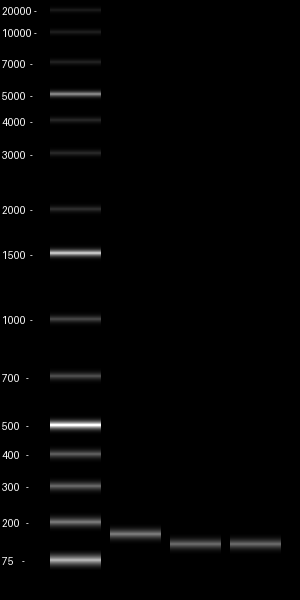

In [17]:
from pydna.gel import gel
from pydna.ladders import GeneRuler_1kb_plus

bands = list_of_amplicons
for band in bands:
    print(band.name)

gel([GeneRuler_1kb_plus, *[[band] for band in bands]])

In [18]:
overhangs = create_overhang_dataframe(list_of_amplicons)
overhangs

,Amplicon Name,5' Overhang,5' Duplicate,3' Overhang,3' Duplicate
0,Amplicon_SCO5090_140_pcr_products,CATG,No,GGGA,No
1,Amplicon_SCO5090_208_pcr_products,GGGA,No,GTCG,No
2,Amplicon_SCO5087_522_pcr_products,GTCG,No,CTAG,No


In [19]:
digest_amplicons = digest_amplicons_w_BsaI(list_of_amplicons)
for digest in digest_amplicons: 
    print(digest.figure())

Dseqrecord(-138)
CATGGTTCACTGCCGTATAGGCAGCTAAGAAACACGTACAGGTCCTGGAGCGGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    CAAGTGACGGCATATCCGTCGATTCTTTGTGCATGTCCAGGACCTCGCCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAACCCT
Dseqrecord(-106)
GGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    GCAGGTCCAGAAGTGGCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAACAGC
Dseqrecord(-106)
GTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTATCAACTTGAAAAAGTGGCACCGAGTCGGTGCTTTTTT    
    TGGAGGGTCAGTGCCGCAAAATCTCGATCTTTATCGTTCAATTTTATTCCGATCAGGCAATAGTTGAACTTTTTCACCGTGGCTCAGCCACGAAAAAAGATC


In [20]:
digest_amplicons

[Dseqrecord(-138), Dseqrecord(-106), Dseqrecord(-106)]

In [21]:

from Bio.Restriction import NcoI, NheI

try:
    linear_plasmid, smaller_frag = sorted(clean_plasmid.cut(NcoI, NheI), key=lambda x: len(x), reverse=True)
    for i in range(len(digest_amplicons)):
        # Assuming digest_amplicons[i] is a Dseqrecord, concatenate Dseq sequences
        linear_plasmid.seq += digest_amplicons[i].seq
    
    try:
        rec_vec = linear_plasmid.looped()
        print("Successfully looped the plasmid.")
    except Exception as e:
        print(f"An error occurred while trying to loop the plasmid: {e}")
        # Handle the error or provide an alternative action here
        rec_vec = None  # Example response; adjust as needed

except Exception as e:
    print(f"An error occurred during plasmid digestion or preparation: {e}")
    # Additional error handling or cleanup here
    rec_vec = None  # Ensure rec_vec is defined even if an error occurs

Successfully looped the plasmid.


In [22]:
# Constructing a meaningful name, ID, and description for the assembled plasmid using user input
plasmid_components = "_".join(genes_to_KO)  # Concatenates gene names from the user's list
plasmid_purpose = f"pCRISPR-mcBEST_{len(filtered_df)}_sgrnas"  # Example: purpose of the plasmid

rec_vec.name = f'{plasmid_purpose}'#_{plasmid_components}'
rec_vec.id = rec_vec.name  # Using the same value for ID as for name for simplicity
rec_vec.description = f'CRISPR-mcBEST_plasmid {", ".join(genes_to_KO)} for gene KNOCK-DOWN, assembled using StreptoCAD.'
rec_vec.id

'pCRISPR-mcBEST_3_sgrnas'

In [23]:
# annotate the plasmid correctly
annotate_plasmid_with_sgrnas(rec_vec, filtered_df)

Dseqrecord(o12802)

In [24]:
print_plasmid = False

if print_plasmid: 
    rec_vec.write(f"../../data/plasmids/sgRNA_plasmids_pCRISPR_mcBEST/{rec_vec.id}.gb")


In [25]:
rec_vec

Dseqrecord(o12802)

In [26]:
integration_names = filtered_df.apply(lambda row: f"sgRNA_{row['locus_tag']}({row['sgrna_loc']})_", axis=1).tolist()
integration_names = ''.join(integration_names)
integration_names

'sgRNA_SCO5090(140)_sgRNA_SCO5090(208)_sgRNA_SCO5087(522)_'

In [27]:
integration_names = filtered_df.apply(lambda row: f"sgRNA_{row['locus_tag']}({row['sgrna_loc']})", axis=1).tolist()
integration_names = [';'.join(integration_names)]

plasmid_metadata_df = extract_metadata_to_dataframe([rec_vec],
                                                    clean_plasmid,
                                                    integration_names)

plasmid_metadata_df

,plasmid_name,date,original_plasmid,integration,size
0,pCRISPR-mcBEST_3_sgrnas,2024-10-25,pCRISPR-mcBEST,sgRNA_SCO5090(140);sgRNA_SCO5090(208);sgRNA_SC...,12802


In [28]:
pd.set_option('display.max_columns', None)


In [29]:

# Getting checking primers
checking_primers_df = find_best_check_primers_from_genome(genome, 
                                       genes_to_KO, 
                                       flanking_region=flanking_region,
                                       target_tm = melting_temperature, 
                                        primer_concentration = primer_concentration, 
                                        polymerase = chosen_polymerase)
checking_primers_df

,locus tag,f_primer_name,r_primer_name,f_primer_sequences(5-3),r_primer_sequences(5-3),f_tm,r_tm,ta,flanking_region,annealing_temperature,primer_pair,homodimer_forward_tm,homodimer_forward_deltaG (kcal/mol),homodimer_reverse_tm,homodimer_reverse_deltaG (kcal/mol),heterodimer_tm,heterodimer_deltaG (kcal/mol),hairpin_forward_structure_found,hairpin_forward_tm,hairpin_forward_deltaG (kcal/mol),hairpin_reverse_structure_found,hairpin_reverse_tm,hairpin_reverse_deltaG (kcal/mol)
0,SCO5087,SCO5087_fwd_checking_primer,SCO5087_rev_checking_primer,TAGGGCGCGGC,CCGGAGACCACCAG,51,53,55,550,55,SCO5087_fwd_checking_primer & SCO5087_rev_chec...,26.385240,-5.886397,-15.268430,-3.528618,-34.382170,-1.534614,False,0.0,0.0,False,0.0,0.0
1,SCO5089,SCO5089_fwd_checking_primer,SCO5089_rev_checking_primer,CCCTTCGACGAGCG,CGGGGCCGGT,54,49,53,600,53,SCO5089_fwd_checking_primer & SCO5089_rev_chec...,-5.338917,-1.468854,1.902964,-3.360252,-36.526236,-1.541041,False,0.0,0.0,False,0.0,0.0
2,SCO5090,SCO5090_fwd_checking_primer,SCO5090_rev_checking_primer,CGAGCTGGACGCC,CGACGACCACCTCG,54,54,58,600,58,SCO5090_fwd_checking_primer & SCO5090_rev_chec...,-27.967369,-2.788697,-29.701198,-2.176432,10.025082,-1.435609,False,0.0,0.0,False,0.0,0.0


In [30]:
# making the primers into dseqrecords
checking_primers_df_idt = create_idt_order_dataframe(checking_primers_df)
checking_primers_df_idt


,Name,Sequence,Concentration,Purification
0,SCO5087_fwd_checking_primer,TAGGGCGCGGC,25nm,STD
1,SCO5089_fwd_checking_primer,CCCTTCGACGAGCG,25nm,STD
2,SCO5090_fwd_checking_primer,CGAGCTGGACGCC,25nm,STD
3,SCO5087_rev_checking_primer,CCGGAGACCACCAG,25nm,STD
4,SCO5089_rev_checking_primer,CGGGGCCGGT,25nm,STD
5,SCO5090_rev_checking_primer,CGACGACCACCTCG,25nm,STD


In [31]:
full_idt = pd.concat([idt_df, checking_primers_df_idt])
full_idt

,Name,Sequence,Concentration,Purification
0,fwd_primer_SCO5090_140,GATCGGGTCTCCCATGGTTCACTGCCGTATAGGCAGCTAAGAAACA...,25nm,STD
1,fwd_primer_SCO5090_208,GATCGGGTCTCCGGGACGTCCAGGTCTTCACCGTTTTAGAGCTAGA...,25nm,STD
2,fwd_primer_SCO5087_522,GATCGGGTCTCCGTCGACCTCCCAGTCACGGCGTTTTAGAGCTAGA...,25nm,STD
3,rev_primer_SCO5090_140,GATCAGGTCTCGTCCCAAAAAAGCACCGACTCG,25nm,STD
4,rev_primer_SCO5090_208,GATCAGGTCTCGCGACAAAAAAGCACCGACTCG,25nm,STD
5,rev_primer_SCO5087_522,GATCAGGTCTCGCTAGAAAAAAGCACCGACTCG,25nm,STD
0,SCO5087_fwd_checking_primer,TAGGGCGCGGC,25nm,STD
1,SCO5089_fwd_checking_primer,CCCTTCGACGAGCG,25nm,STD
2,SCO5090_fwd_checking_primer,CGAGCTGGACGCC,25nm,STD
3,SCO5087_rev_checking_primer,CCGGAGACCACCAG,25nm,STD


## Folder with all the generated I/O

In [32]:
get_data_folder = False

In [33]:
if get_data_folder: 
    # Example: 

    input_files = [
        {"name": "input_genome.gb", "content": genome},
        {"name": "input_plasmid.gb", "content": clean_plasmid}
    ]

    output_files = [
        {"name": "mcBEST_w_sgRNAs.gb", "content": rec_vec},
        {"name": "overhang_df.csv", "content": overhangs},
        {"name": "pcr_df.csv", "content": primer_df},
        {"name": "full_idt.csv", "content": full_idt},
        {"name": "mutated_sgrna_df.csv", "content": mutated_sgrna_df},
        {"name": "filtered_df.csv", "content": filtered_df},
        {"name": "plasmid_metadata_df.csv", "content": plasmid_metadata_df},
    ]

    input_values = {
        "genes_to_knockout": ['SCO5087', 'SCO5089', 'SCO5090'],
        "filtering_metrics": {
            "gc_upper": gc_upper,
            "gc_lower": gc_lower,
            "off_target_seed": off_target_seed,
            "off_target_upper": off_target_upper,
            "cas_type": cas_type,
            "number_of_sgRNAs_per_group": number_of_sgRNAs_per_group
        },
        "polymerase_settings": {
            "chosen_polymerase": chosen_polymerase,
            "melting_temperature": melting_temperature,
            "primer_concentration": primer_concentration,
            "flanking_region": flanking_region
        }, # TODO might want to incorporate this to the app
        "overlapping_sequences": {
            "restriction_overhang_f": restriction_overhang_f,
            "restriction_overhang_r": restriction_overhang_r,
            "backbone_overhang_f": backbone_overhang_f,
            "backbone_overhang_r": backbone_overhang_r,
            "cys4": cys4,
            "sgRNA_handle_cys4_site": str(sgRNA_handle_cys4_site[0].seq)
        }
    }


    # Paths to Markdown files
    markdown_file_paths = [
        "../../protocols/conjugation_protcol.md",
        "../../protocols/multi_target_crispr_plasmid_protcol.md"

    ]

    # Data and time
    timestamp = datetime.utcnow().isoformat()
    project_name=f"CRISPR_mcBEST_workflow_{timestamp}"


    # Create project directory structure
    project_directory = ProjectDirectory(
        project_name=project_name,
        input_files=input_files,
        output_files=output_files,
        input_values=input_values,
        markdown_file_paths=markdown_file_paths
    )


    # DO You want to save the folder? 
    save_zip_folder = False 

    if save_zip_folder: 
        # Generate the project directory structure and get the zip content
        zip_content = project_directory.create_directory_structure(create_directories=False)

        # Save the zip file to disk (optional)
        with open("project_structure.zip", "wb") as f:
            f.write(zip_content)